In [ ]:
import pandas as pd
import datetime
import numpy as np
import json
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer,TweetTokenizer

import string
import re

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold,StratifiedKFold,RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline



import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from scipy.stats import uniform, randint as sp_randint
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')


## Preprocessing and Cleaning

In [ ]:
def merge(x):
    for i in x:
        clean = pd.read_json("189/" + i +"just_tweets.json")

        cleanext = pd.read_json("189/" + i + ".json")
        clean.columns  = ['favorite_count', 'full_text']
        
        
        bank = [i.encode('ascii', 'ignore').decode('ascii') for i in clean['full_text']]
        clean['full_text'] = bank
        clean['full_text'] = clean['full_text'].astype(str)

        bank1 = [i.encode('ascii', 'ignore').decode('ascii') for i in cleanext['full_text']]
        cleanext['full_text'] = bank1
        cleanext['full_text'] = cleanext['full_text'].astype(str)
        
        aoc = pd.merge(clean,cleanext, on = 'full_text')
        aoc_lda = pd.read_csv("189/" + i + ".csv")

        
        aoc_lda['tweet_orig'] = aoc['full_text']
        aoc_lda["date"] = aoc["created_at"]
        
        aoc_lda.to_csv("try" + i + ".csv")
        
x = ['AOC','elonmusk','realDonaldTrump']
merge(x)

In [2]:
elon = pd.read_csv("tryelo.csv")
AOC = pd.read_csv("tryAOC.csv")
trump = pd.read_csv("tryrealDonaldTrump.csv")
elon_raw = elon['tweet_orig']
AOC_raw = AOC['tweet_orig']
trump_raw = trump['tweet_orig']

In [4]:

def clean_text(tuk_text):
    email_at = []
    for i in tuk_text:
        email_at.append((re.findall(r"(\@+[\w_]+)",i)))
        email_at = [x for x in email_at if x != []]
        email_at = [at.lower() for x in email_at for at in x]
    
    
    hash1 = []
    for i in tuk_text:
        hash1.append((re.findall(r"(\#+[\w_]+)",i)))     #find all hashtags
        hash1 = [x for x in hash1 if x != []]
        hash1 = [hash.lower() for x in hash1 for hash in x]
        
        
    tuk_ready_stem = []
    from nltk.stem.snowball import SnowballStemmer

    stem = SnowballStemmer("english") 

    stopw = stopwords.words('english') + list(string.punctuation)  +["’","”","—","“"] + hash1 + email_at
    for i in tuk_text:
        tokens = [stop for stop in TweetTokenizer().tokenize(i.lower()) if stop not in stopw]
        tokens = [w for w in tokens if w.isalpha()]
        tokens = [w for w in tokens if re.findall(r"(\w{3})",w) ]
        #tokens = [stem.stem(w) for w in tokens]
        review = ' '.join(tokens)
        review = re.sub(r'((.)\2{2,})', ' ', review)
        tuk_ready_stem.append(review)
    return(tuk_ready_stem)

In [5]:
elon_clean = clean_text(elon_raw)
AOC_clean = clean_text(AOC_raw)
trump_clean = clean_text(trump_raw)

elon["clean"] = elon_clean
AOC["clean"] = AOC_clean
trump["clean"] = trump_clean

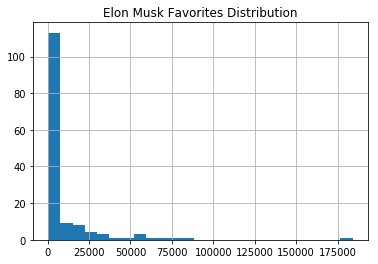

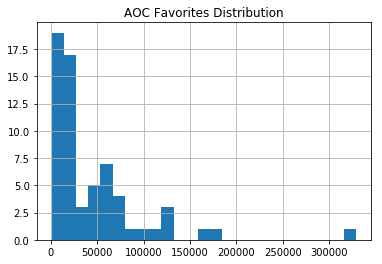

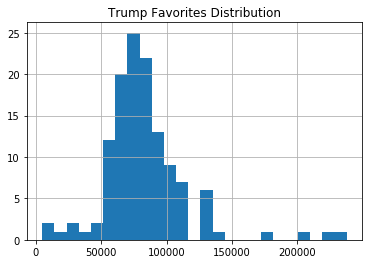

In [42]:
for h,i in enumerate([elon, AOC, trump]):
    b = ["Elon Musk Favorites Distribution", "AOC Favorites Distribution", "Trump Favorites Distribution"]
    i["favorite_count"].hist(bins=25)
    plt.title(b[h])
    plt.show()

## Feature Generation

In [6]:
def weekhourbin():
    x = [elon,trump,AOC]
    for i in x:
        weekday =[datetime.datetime.strptime(j, "%m/%d/%Y %H:%M").weekday() for j in i['date']]
        i['weekday'] = weekday
        
        hour =  [0 if datetime.datetime.strptime(j, "%m/%d/%Y %H:%M").hour >= 0 
         and datetime.datetime.strptime(j, "%m/%d/%Y %H:%M").hour <= 8 
         else 1 if datetime.datetime.strptime(j, "%m/%d/%Y %H:%M").hour >= 9 
         and datetime.datetime.strptime(j, "%m/%d/%Y %H:%M").hour <= 17 else 2 for j in i['date']]
        i['hour'] = hour
        
    
weekhourbin()

In [7]:
elon = pd.get_dummies(elon, columns = ['weekday','hour'])
AOC = pd.get_dummies(AOC, columns = ['weekday','hour'])
trump = pd.get_dummies(trump, columns = ['weekday','hour'])

In [ ]:
# length= int(len(elon)/3)
elon_final = elon.sort_values('favorite_count')
elon_final['fav_bin'] = 2
elon_final['fav_bin'][0:length] = 0
elon_final['fav_bin'][length:length*2] = 1

length= int(len(AOC)/3)
AOC_final = AOC.sort_values('favorite_count')
AOC_final['fav_bin'] = 2
AOC_final['fav_bin'][0:length] = 0
AOC_final['fav_bin'][length:length*2] = 1

length= int(len(trump)/3)
trump_final = trump.sort_values('favorite_count')
trump_final['fav_bin'] = 2
trump_final['fav_bin'][0:length] = 0
trump_final['fav_bin'][length:length*2] = 1



In [9]:
elon_f =  elon_final.drop(["Unnamed: 0", "tweet", "favorite_count", "tweet_orig", "date"],axis = 1)
AOC_f =  AOC_final.drop(["Unnamed: 0", "tweet", "favorite_count", "tweet_orig", "date"],axis = 1)
trump_f =  trump_final.drop(["Unnamed: 0", "tweet", "favorite_count", "tweet_orig", "date"],axis = 1)

## Implenting models

In [12]:
def modelo(df):
    scores = []
    Xmain = df.drop(['fav_bin'],axis = 1)
    y = df['fav_bin']
    X_train_text,X_test_text,y_train,y_test=train_test_split(Xmain,
                                              y,
                                                train_size = 0.75,
                                               stratify = y,
                                              random_state=9)
    vect = TfidfVectorizer(min_df=3,ngram_range=(1,2)).fit(X_train_text["clean"])
    X_train_vectorized = vect.transform(X_train_text["clean"])
    X_test_vectorized = vect.transform(X_test_text["clean"])
    
    X_train_dtm= pd.concat([pd.DataFrame(X_train_vectorized.toarray()), X_train_text.drop(["clean"], axis = 1).reset_index(drop=True)], axis=1)
    X_test_dtm = pd.concat([pd.DataFrame(X_test_vectorized.toarray()), X_test_text.drop(["clean"], axis = 1).reset_index(drop=True)], axis=1)
    print("-"*60)
    print("Model 1: Logistic Regression")
    clf = [("Robust",StandardScaler()),('Log',LogisticRegression())]  #Feature Scaling manual gridsearch yeilded 1 as best
    piped = Pipeline(clf)
    piped.fit(X_train_dtm,y_train)
    pred = piped.predict(X_test_dtm)
    scores.append(round(accuracy_score(y_test,pred)*100,2))
    print("The accuracy score from Logistic Regression is, ", round(accuracy_score(y_test,pred)*100,2), "%")
    
    print("-"*60)
    print("Model 2: LightGBM")
    lg_clf = LGBMClassifier()
    lg_cl = Pipeline([("Robust",StandardScaler()),('LGB',lg_clf)])  #Feature Scaling and SVM classifier

    params = { "LGB__objective" : ["multiclass"],   
          "LGB__num_class" : [3],
          "LGB__n_estimator": sp_randint(50,1000),
          "LGB__learning_rate" : [0.1,0.12,0.13,0.09,0.15],
          "LGB__metric":["softmax","multi_logloss"],
         "LGB__boosting_type": ['dart'],
         "LGB__feature_fraction":[0.75,0.8,0.85],
         "LGB__bagging_freq": [1,0],
         "LGB__bagging_fraction": [0.83,0.85,0.87],
         "LGB__max_drop": sp_randint(5,50),
         "LGB__drop_rate": [0.01,0.05,0.07],
         "LGB__max_depth": sp_randint(1,20),
         "LGB__num_leaves":sp_randint(5,40)} #param grid
    trial = RandomizedSearchCV(lg_cl,param_distributions = params, n_iter = 200, scoring = "accuracy", cv = 10,verbose = 3, n_jobs = -1)
    trial.fit(X_train_dtm,y_train) #Train model
    print("The best 10 fold CV accuracy score  is, ", round(trial.best_score_*100,2),"%") #best accuracy
    print("The best parameters are ,", trial.best_params_) #best params
    pred2 = trial.predict(X_test_dtm)
    scores.append(round(accuracy_score(y_test,pred2)*100,2))
    print("The accuracy score from LightGBM is, ", round(accuracy_score(y_test,pred2)*100,2), "%")
    
    print("-"*60)
    print("Model 3: XGBoost")
    pip = [("Robust",StandardScaler()),("XG",XGBClassifier())]
    xg = Pipeline(pip)
    parameters = {
              'XG__objective':['multi:softmax'],
              'XG__learning_rate': [0.01,0.02,0.03,0.05,0.07,0.1,0.15], 
              'XG__max_depth': [6,7,8,10,15],
              'XG__min_child_weight': [1,2,3,5,7,11,20],
              'XG__silent': [1],
              'XG__subsample': [0.8,1,0.5],
              'XG__colsample_bytree': [0.7,1,0.5],
              'XG__n_estimators': sp_randint(15,500), 
              'XG__missing':[-999],
              'XG__seed': [1337],
             'XG__gamma':[0,5,10,15],
             'XG__num_class':[3]} #param grid
    gg = RandomizedSearchCV(xg, parameters,n_iter = 200,  
                   cv=5, 
                   scoring='accuracy',
                   verbose=2, refit=True, n_jobs = -1)
    gg.fit(X_train_dtm,y_train) #train model
    print("The best 10 fold CV accuracy score  is, ", round(gg.best_score_*100,2),"%") #best accuracy
    print("The best parameters are ,", gg.best_params_) #best params
    pred3 = gg.predict(X_test_dtm)
    scores.append(round(accuracy_score(y_test,pred3)*100,2))
    print("The accuracy score from XGBoost is, ", round(accuracy_score(y_test,pred3)*100,2), "%")
    
    print("-"*60)
    print("Model 4: Random Forests")
    clf = [("Robust",StandardScaler()),("RF",RandomForestClassifier())] #Feature Scaling and SVM classifier
    rf = Pipeline(clf)
    param_grid = {
    'RF__max_depth': sp_randint(3,80),
    'RF__max_features': ["auto"],
    'RF__min_samples_leaf': sp_randint(1,20),
    'RF__min_samples_split': sp_randint(2,20),
    'RF__n_estimators': sp_randint(20,500)} #param grid
    trial3 = RandomizedSearchCV(rf,param_distributions = param_grid, n_iter = 400, scoring = "accuracy", cv = 10,verbose = 3, n_jobs = -1)
    trial3.fit(X_train_dtm,y_train)
    print("The best 10 fold CV accuracy score  is, ", round(trial3.best_score_*100,2),"%") #best accuracy
    print("The best parameters are ,", trial3.best_params_) #best params
    pred4 = trial3.predict(X_test_dtm)
    scores.append(round(accuracy_score(y_test,pred4)*100,2))
    print("The accuracy score from XGBoost is, ", round(accuracy_score(y_test,pred4)*100,2), "%")
    
    return(scores)

In [13]:
elon_model = modelo(elon_f)

------------------------------------------------------------
Model 1: Logistic Regression
The accuracy score from Logistic Regression is,  56.76 %
------------------------------------------------------------
Model 2: LightGBM
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 117 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 437 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 885 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 1461 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 1977 out of 2000 | elapsed:   18.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   18.4s finished


The best 10 fold CV accuracy score  is,  52.73 %
The best parameters are , {'LGB__bagging_fraction': 0.83, 'LGB__bagging_freq': 1, 'LGB__boosting_type': 'dart', 'LGB__drop_rate': 0.07, 'LGB__feature_fraction': 0.85, 'LGB__learning_rate': 0.09, 'LGB__max_depth': 15, 'LGB__max_drop': 30, 'LGB__metric': 'softmax', 'LGB__n_estimator': 606, 'LGB__num_class': 3, 'LGB__num_leaves': 18, 'LGB__objective': 'multiclass'}
The accuracy score from LightGBM is,  35.14 %
------------------------------------------------------------
Model 3: XGBoost
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.9min finished


The best 10 fold CV accuracy score  is,  56.36 %
The best parameters are , {'XG__colsample_bytree': 1, 'XG__gamma': 0, 'XG__learning_rate': 0.02, 'XG__max_depth': 15, 'XG__min_child_weight': 2, 'XG__missing': -999, 'XG__n_estimators': 59, 'XG__num_class': 3, 'XG__objective': 'multi:softmax', 'XG__seed': 1337, 'XG__silent': 1, 'XG__subsample': 1}
The accuracy score from XGBoost is,  37.84 %
------------------------------------------------------------
Model 4: Random Forests
Fitting 10 folds for each of 400 candidates, totalling 4000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   54.2s
[Parallel(n_jobs=-1)]: Done 1544 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2024 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 3848 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed:  3.0min finished


The best 10 fold CV accuracy score  is,  54.55 %
The best parameters are , {'RF__max_depth': 77, 'RF__max_features': 'auto', 'RF__min_samples_leaf': 16, 'RF__min_samples_split': 6, 'RF__n_estimators': 344}
The accuracy score from XGBoost is,  40.54 %


In [15]:
AOC_model = modelo(AOC_f)

------------------------------------------------------------
Model 1: Logistic Regression
The accuracy score from Logistic Regression is,  50.0 %
------------------------------------------------------------
Model 2: LightGBM
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 813 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 1709 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 1977 out of 2000 | elapsed:   14.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   14.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


The best 10 fold CV accuracy score  is,  47.92 %
The best parameters are , {'LGB__bagging_fraction': 0.87, 'LGB__bagging_freq': 0, 'LGB__boosting_type': 'dart', 'LGB__drop_rate': 0.01, 'LGB__feature_fraction': 0.8, 'LGB__learning_rate': 0.15, 'LGB__max_depth': 17, 'LGB__max_drop': 30, 'LGB__metric': 'multi_logloss', 'LGB__n_estimator': 625, 'LGB__num_class': 3, 'LGB__num_leaves': 38, 'LGB__objective': 'multiclass'}
The accuracy score from LightGBM is,  31.25 %
------------------------------------------------------------
Model 3: XGBoost
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.8min finished


The best 10 fold CV accuracy score  is,  60.42 %
The best parameters are , {'XG__colsample_bytree': 0.5, 'XG__gamma': 0, 'XG__learning_rate': 0.03, 'XG__max_depth': 7, 'XG__min_child_weight': 3, 'XG__missing': -999, 'XG__n_estimators': 322, 'XG__num_class': 3, 'XG__objective': 'multi:softmax', 'XG__seed': 1337, 'XG__silent': 1, 'XG__subsample': 1}
The accuracy score from XGBoost is,  31.25 %
------------------------------------------------------------
Model 4: Random Forests
Fitting 10 folds for each of 400 candidates, totalling 4000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   56.7s
[Parallel(n_jobs=-1)]: Done 1544 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2024 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 3848 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed:  2.9min finished


The best 10 fold CV accuracy score  is,  58.33 %
The best parameters are , {'RF__max_depth': 66, 'RF__max_features': 'auto', 'RF__min_samples_leaf': 1, 'RF__min_samples_split': 14, 'RF__n_estimators': 88}
The accuracy score from XGBoost is,  37.5 %


In [16]:
trump_model = modelo(trump_f)

------------------------------------------------------------
Model 1: Logistic Regression
The accuracy score from Logistic Regression is,  34.38 %
------------------------------------------------------------
Model 2: LightGBM
Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 952 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:   14.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


The best 10 fold CV accuracy score  is,  26.32 %
The best parameters are , {'LGB__bagging_fraction': 0.87, 'LGB__bagging_freq': 1, 'LGB__boosting_type': 'dart', 'LGB__drop_rate': 0.05, 'LGB__feature_fraction': 0.85, 'LGB__learning_rate': 0.1, 'LGB__max_depth': 11, 'LGB__max_drop': 40, 'LGB__metric': 'softmax', 'LGB__n_estimator': 505, 'LGB__num_class': 3, 'LGB__num_leaves': 29, 'LGB__objective': 'multiclass'}
The accuracy score from LightGBM is,  31.25 %
------------------------------------------------------------
Model 3: XGBoost
Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   31.9s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  3.1min finished


The best 10 fold CV accuracy score  is,  40.0 %
The best parameters are , {'XG__colsample_bytree': 1, 'XG__gamma': 5, 'XG__learning_rate': 0.02, 'XG__max_depth': 7, 'XG__min_child_weight': 2, 'XG__missing': -999, 'XG__n_estimators': 209, 'XG__num_class': 3, 'XG__objective': 'multi:softmax', 'XG__seed': 1337, 'XG__silent': 1, 'XG__subsample': 0.8}
The accuracy score from XGBoost is,  21.88 %
------------------------------------------------------------
Model 4: Random Forests
Fitting 10 folds for each of 400 candidates, totalling 4000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 104 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 488 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done 1544 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2024 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 3848 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed:  2.9min finished


The best 10 fold CV accuracy score  is,  34.74 %
The best parameters are , {'RF__max_depth': 21, 'RF__max_features': 'auto', 'RF__min_samples_leaf': 2, 'RF__min_samples_split': 19, 'RF__n_estimators': 87}
The accuracy score from XGBoost is,  31.25 %


In [20]:
summary = pd.DataFrame({"Elon Musk": elon_model,
                       "AOC": AOC_model,
                       "Trump": trump_model})
#summary.index["Logistic Regression", "LightGBM", "XGBoost", "Random Forests"]

In [23]:
summary.index = ["Logistic Regression", "LightGBM", "XGBoost", "Random Forests"]

In [24]:
summary

,Elon Musk,AOC,Trump
Logistic Regression,56.76,50.00,34.38
LightGBM,35.14,31.25,31.25
XGBoost,37.84,31.25,21.88
Random Forests,40.54,37.50,31.25
